In [1]:
import pandas as pd
import numpy as np
import os
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import re
import math

In [2]:
def loadEverything():
    all_projects_bugreports = pd.read_pickle('GlobalOutput/allBugReports.pickle')
    print("*** All Bug Reports are Loaded. ***")
    all_projects_source_codes = pd.read_pickle('GlobalOutput/allSourceCodes.pickle')
    print("*** All Source Codes are Loaded. ***")
    return all_projects_bugreports, all_projects_source_codes

all_projects_bugreports, all_projects_source_codes = loadEverything()

display(all_projects_source_codes.head())
display(all_projects_bugreports.head())

*** All Bug Reports are Loaded. ***
*** All Source Codes are Loaded. ***


filename  \
0  \gitrepo\camel-core\src\main\java\org\apache\c...   
1  \gitrepo\camel-core\src\main\java\org\apache\c...   
2  \gitrepo\camel-core\src\main\java\org\apache\c...   
3  \gitrepo\camel-core\src\main\java\org\apache\c...   
4  \gitrepo\camel-core\src\main\java\org\apache\c...   

                                    unprocessed_code project  
0  /**\n * Licensed to the Apache Software Founda...   CAMEL  
1  /**\n * Licensed to the Apache Software Founda...   CAMEL  
2  /**\n * Licensed to the Apache Software Founda...   CAMEL  
3  /**\n * Licensed to the Apache Software Founda...   CAMEL  
4  /**\n * Licensed to the Apache Software Founda...   CAMEL

fix text  \
id                                                            
72   [org.apache.camel.component.file.fileconfigure...  NaN   
81         [org.apache.camel.impl.servicesupport.java]  NaN   
85    [org.apache.camel.component.vm.vmcomponent.java]  NaN   
105  [org.apache.camel.component.file.fileproducer....  NaN   
103  [org.apache.camel.spring.camelcontextfactorybe...  NaN   

                 fixdate                                            summary  \
id                                                                            
72   2007-07-09 09:00:19   FileConfigureTest can&apos;t pass in Windows box   
81   2007-07-30 16:49:10        Stop logic a bit off in ServiceSupport.java   
85   2007-08-03 20:18:56          VM Component should extend Seda not Queue   
105  2007-08-14 21:43:05      FileProducer truncates message bodies > 256KB   
103  2007-08-17 04:42:11  ClassCastException when using GenericApplicati...   

                                           description project  \
id                                                               
72   Because of the File.separator is different bet...   CAMEL   
81   With the current logic, during stop the servic...   CAMEL   
85   It appears that the deprecation of the Queue c...   CAMEL   
105  Thanks to NIO&amp;apos;s awesomely intuitive b...   CAMEL   
103  \nCaused by: java.lang.ClassCastException:\nor...   CAMEL   

     average_precision  
id                      
72                 0.0  
81                 0.0  
85                 0.0  
105                0.0  
103                0.0

#### Removing New Lines

In [3]:
#remove next line characters:
def remove_new_lines(text):
    text = str(text)
    COMBINE_WHITE_SPACE = re.compile(r"(?a:\s+)")
    text = COMBINE_WHITE_SPACE.sub(' ', text)
    return text.replace('*', '').replace('/', '').replace('\\','')
    
# clean up the various white space and remove some *
def clean_new_lines_source_code(df):
    df.unprocessed_code = df.unprocessed_code.apply(remove_new_lines)
    return df

# clean up the description and summary, they will both be used for the query
def clean_new_lines_bug_report(df):
    df.summary = df.summary.apply(remove_new_lines)
    df['description'] = df['description'].astype('|U')
    df.description = df.description.apply(remove_new_lines)
    return df

#### Cleaning file paths

In [4]:
# changes file path to be just the filename + extension for source code files
def clean_sc_file(x):
    file = x.split("\\")
    return ''.join(file[-1:])

# changes file path to be just the filename + extension for bug report fixes 
def clean_bug_file(x):
    fixes = []

    for file in x:
        file = file.split(".")
        file = '.'.join(file[-2:])
        fixes.append(file)
    return fixes


def clean_sc_filepath(df):
    df.filename = df.filename.map(clean_sc_file)
    return df


def clean_bug_filepath(df):
    df['fix'] = df['fix'].map(clean_bug_file)
    return df

#### Cleaning Composite Words

In [5]:
#splitting composite words
#splits using camlecase syntax
def findCompositeWords(s):
    return ' '.join(re.findall('[A-Z][^A-Z]*', s))   


def clean_composite_source_code(df):
    df.unprocessed_code = df.unprocessed_code.apply(findCompositeWords)
    return df

def clean_composite_bug_report(df):
    df.summary = df.summary.apply(findCompositeWords)
    df.description = df.description.apply(findCompositeWords)
    return df

#### Remove fixes that can't be found

In [6]:
# look through the src data frame to find where the fix is. 
def get_fix_indexes(bug, src):
    fix_list = list()
    for fixes in bug["fix"]:
        fix_sub=list()
        for fix in fixes:
            df = src[src["filename"].str.match(fix)]
            if(df.shape[0] != 0):
                fix_sub.append(df.index[0])
            else:
                fix_sub.append(-1)
        fix_list.append(fix_sub)
    # this is a list of the indexes of the file where the fix was located
    return fix_list

In [7]:
def removeFixesNotFound(bug, src):
    bug["fix_indexes"] = get_fix_indexes(bug, src)
    fixes = bug.fix.tolist()
    fix_indexes = bug.fix_indexes.tolist()
    fixes_return = []
    fixes_indexes_return = []
    numFixes = []
    for i in range(len(fixes)):
        fixes_temp = []
        indexes_temp = []
        numFixes.append(len(fix_indexes[i]))
        for l in range(len(fix_indexes[i])):
            if fix_indexes[i][l] != -1:           
                fixes_temp.append(fixes[i][l])
                indexes_temp.append(fix_indexes[i][l])
        if len(fixes_temp) == 0:
            fixes_return.append(np.nan)
            fixes_indexes_return.append(np.nan)
        else:
            fixes_return.append(fixes_temp)
            fixes_indexes_return.append(indexes_temp)
        
#         print(fixes_return)
#         print(fixes_indexes_return)
    bug['numFixes'] = numFixes
    bug['fix'] = fixes_return
    bug['fix_indexes'] = fixes_indexes_return 
    
    return bug

#### Calling cleaning functions

In [8]:
# clean up the unprocessed code column
def clean_source_df(df):
    # clean up the new lines
    df = clean_new_lines_source_code(df)
    # clean up composite words
    df = clean_composite_source_code(df)
    # clean filepaths
    df = clean_sc_filepath(df)
    return df

# add the summary and description together and clean the data
def clean_combine_bug_df(df):
    # clean up new lines
    df = clean_new_lines_bug_report(df)
    # clean composite words
    df = clean_composite_bug_report(df)
    # clean file path
    df = clean_bug_filepath(df)
    # combine summary and descriptions to create query
    df["query"] = df["summary"] + df["description"]
    return df



### Run Cleaning and Setup Functions

In [9]:
all_projects_bugreports = all_projects_bugreports.dropna(axis=0, subset=['fix'], how='all')

#  get clean versions of the dataframes
sc_df = clean_source_df(all_projects_source_codes)
br_df = clean_combine_bug_df(all_projects_bugreports)


# remove fixes that aren't found
br_df = removeFixesNotFound(br_df, sc_df)
br_df = br_df.dropna(axis=0, subset=['fix','fix_indexes'], how='all')


### Save the clean DFs as pickle files to prevent having to clean them again

In [10]:
sc_df.to_pickle("./GlobalOutput/cleanSource.pickle")
br_df.to_pickle("./GlobalOutput/cleanBugs.pickle")

#### Combining stop words, keywords and operators

In [12]:
# add the Java key words to the stop words
java_keywords = ["abstract", "assert**","assert", "boolean", "break", "byte", "case", "catch", "char", "const", "continue", "default", "do", "double", "else", "enum", "enum****" "extends", "final", "finally", "for", "goto","goto*", "if", "implements", "import", "instanceof", "int","interface", "long", "native", "new", "package", "private", "protected", "public", "return", "short", "static", "strictfp**","strictfp", "super", "switch", "synchornized", "this", "throw", "throws", "transient", "try", "void", "volatile", "while"]
java_operators = ["+", "-", "*", "/", "%", "+=", "-=", "*=", "/=", "++", "--", "==", "!=", "<", ">", "<=", ">=", ".", "[", "]", "(",")", "!", "~","instanceof", "<<", ">>", ">>>", "&", "^", "|", "&&", "||", "?", ":", "^=", "%=", "<<=", ">>=", ">>>=", "&="]
stop = java_keywords + java_operators
#contains english stop words, java keywords and java operators
STOP_WORDS = ENGLISH_STOP_WORDS.union(stop)

# remove the stem and stop words
# takes in an array of strings returns an array of strings
def stem_stop(text):
    stemmer = PorterStemmer()   #"english"
    text = text.split()
    text = [w for w in text if not w in STOP_WORDS]
    text = list(map(lambda x: stemmer.stem(x), text))
    text = ' '.join(text)
    text = text.strip()
    return text



## Gensim


### Get a Series with all the source code files and all the bug reports

In [13]:
# create a series with all the source code and all the
sc_df.reset_index(drop=True, inplace=True)
training_src = sc_df.iloc[:, 0:3].copy()
training_src.columns = ['filename', 'query', 'project']

In [14]:
training_bugs = br_df[["query", "project"]].copy()
training_bugs['filename'] = 'bug'
training_bugs.reset_index(drop=True, inplace=True)
training_bugs = training_bugs[['filename', 'query','project']]

In [4]:
# combine the two columns to create a single data frame to train the model
# training_data = pd.concat([training_src, training_bugs], ignore_index=True)
# training_data['query'] = training_data['query'].map(stem_stop)
training_data = pd.read_pickle('GlobalOutput/cleanTrainingData.pickle')
training_data

filename  \
0      alreadystoppedexception.java   
1                asynccallback.java   
2               asyncprocessor.java   
3        asyncproducercallback.java   
4                  attachments.java   
...                             ...   
82377                           bug   
82378                           bug   
82379                           bug   
82380                           bug   
82381                           bug   

                                                   query project  
0      licens apach softwar foundat A S F) contributo...   CAMEL  
1      licens apach softwar foundat A S F) contributo...   CAMEL  
2      licens apach softwar foundat A S F) contributo...   CAMEL  
3      licens apach softwar foundat A S F) contributo...   CAMEL  
4      licens apach softwar foundat A S F) contributo...   CAMEL  
...                                                  ...     ...  
82377  X M L parser load eagerlyw need make use A P I...    WFLY  
82378  cluster X M L reader load eagerlyp M] radoslav...    WFLY  
82379  cannot commun server port offset properti seti...    WFMP  
82380  commands#fail On error default fals unless set...    WFMP  
82381  the wild fli plugin&apos; shutdown(reload=true...    WFMP  

[82382 rows x 3 columns]

### Now start training the Gensim model

In [6]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# get the tagged documents for the doc2vec model
training_docs = [TaggedDocument(doc, [i]) for i, doc in enumerate(list(training_data['query']))]
training_docs

# initialize model
# vector_size = dimensionality of the feature vectors (25, 100, 200)
# window = the max distance bweteeen the predicted word and context words "TUNE"
# alpha = the initial learning rate (says that this will drop as training progresses) start at 0.05? 0.025?
# seed = for reproducibility (MAKE SURE IT WORKS) "TUNE"  [says you need 1 worker for reproducibility]
# min_count = ignore all words with a frequency lower than this
# max_vocab size = limit RAM during vocab building every 1 million words needs 1GB of RAM
# workers = number of worker threads used to train. 
# epochs = number of epochs over the corpus (10-20??)

# time the single run
# %timeit -n1 -r1 doc_model = Doc2Vec(training_docs, vector_size=25, window=3, alpha=0.05, min_count=1, seed=42, workers=1, epochs=20)


[TaggedDocument(words='licens apach softwar foundat A S F) contributor licens agreements. see N O T I C E file distribut work addit inform regard copyright ownership. the A S F licens file you apach license, version 2.0 (the " license"); use file complianc license. you obtain copi licens http:www.apache.orglicens L I C E N S e-2.0 unless requir applic law agre writing, softwar distribut licens distribut " A S I S" B A S I S, W I T H O U T W A R R A N T I E S O R C O N D I T I O N S O F A N Y K I N D, express implied. see licens specif languag govern permiss limit license. org.apache.camel; except thrown situat {@link service} stopped. @version class alreadi stop except extend camel except { serial version U I D = -8721487434390572639 L; alreadi stop exception() { super(" alreadi stopped"); } }', tags=[0]),
 TaggedDocument(words='licens apach softwar foundat A S F) contributor licens agreements. see N O T I C E file distribut work addit inform regard copyright ownership. the A S F licen

In [20]:
%timeit -n1 -r1 doc_model3 = Doc2Vec(training_docs, vector_size=200, window=3, alpha=0.05, min_count=1, seed=42, workers=1, epochs=20)


6min 25s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [105]:
%timeit -n1 -r1 doc_model5 = Doc2Vec(training_docs, vector_size=200, window=3, alpha=0.05, min_count=1, seed=42, workers=6, epochs=20)


3min 6s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


## Currently working with model3

In [8]:
# print the model vocabular
tst_model = Doc2Vec(training_docs, vector_size=300, window=3, alpha = 0.01, min_alpha = 0.0001, min_count=1, seed=42, workers=1, epochs=20, dm=0)
print("trained model 0")
tst_model1 = Doc2Vec(training_docs, vector_size=300, window=3, alpha = 0.01, min_alpha = 0.0001, min_count=1, seed=43, workers=1, epochs=20, dm=0)
print("trained model 1")
tst_model2 = Doc2Vec(training_docs, vector_size=300, window=3, alpha = 0.01, min_alpha = 0.0001, min_count=1, seed=44, workers=1, epochs=20, dm=0)
print("trained model 2")
tst_model3 = Doc2Vec(training_docs, vector_size=300, window=3, alpha = 0.01, min_alpha = 0.0001, min_count=1, seed=45, workers=1, epochs=20, dm=0)
print("trained model 3")
tst_model4 = Doc2Vec(training_docs, vector_size=300, window=3, alpha = 0.01, min_alpha = 0.0001, min_count=1, seed=46, workers=1, epochs=20, dm=0)
print("trained model 4")

# create models w varying seeds
tst_model.save("test_model")
tst_model1.save("test_model1")
tst_model2.save("test_model2")
tst_model3.save("test_model3")
tst_model4.save("test_model4")

trained model 0
trained model 1
trained model 2
trained model 3
trained model 4


In [ ]:
# load models into array
models = []
models.append(Doc2Vec.load("test_model"))
models.append(Doc2Vec.load("test_model1"))
models.append(Doc2Vec.load("test_model2"))
models.append(Doc2Vec.load("test_model3"))
models.append(Doc2Vec.load("test_model4"))

training_data["vector"] =""
training_data1 = training_data.copy()
training_data1["vector"] =""
training_data2 = training_data.copy()
training_data2["vector"] =""
training_data3 = training_data.copy()
training_data3["vector"] =""
training_data4 = training_data.copy()
training_data4["vector"] =""

for i in range(12145):
    training_data["vector"].iloc[i] = models[0][i]
    training_data1["vector"].iloc[i] = models[1][i]
    training_data2["vector"].iloc[i] = models[2][i]
    training_data3["vector"].iloc[i] = models[3][i]
    training_data4["vector"].iloc[i] = models[4][i]

training_data_all_models = []
training_data_all_models.append(training_data)
training_data_all_models.append(training_data1)
training_data_all_models.append(training_data2)
training_data_all_models.append(training_data3)
training_data_all_models.append(training_data4)
training_data_all_models[0]

In [52]:
# all of the vectors have 200 dimensions
print(len(training_data["vector"].iloc[0]))
print(len(training_data["vector"].iloc[1]))
print(len(training_data["vector"].iloc[2]))
print(len(training_data["vector"].iloc[12144]))

200
200
200
200


In [53]:
# testing some of the similarities and the .infer_vector function
from sklearn.metrics.pairwise import cosine_similarity

cosSim_all = []
cosSim2_all = []
tst_vect_all = []

for i in range(len(training_data_all_models)):
    cosSim_all.append(cosine_similarity(training_data_all_models[i]["vector"].iloc[0].reshape(1,-1), training_data_all_models[i]["vector"].iloc[12144].reshape(1,-1)).flatten())
    display(cosSim_all)
    cosSim2_all.append(cosine_similarity(training_data_all_models[i]["vector"].iloc[0].reshape(1,-1), training_data_all_models[i]["vector"].iloc[12143].reshape(1,-1)).flatten())
    display(cosSim2_all)
    tst_vect_all.append(models[i].infer_vector(training_data_all_models[i]["query"].iloc[12143].split()))


    display(training_data_all_models[i]["vector"].shape)
    lst_vects =training_data_all_models[i]["vector"].tolist()
    display(len(lst_vects))
    print("list")
    simList = cosine_similarity(training_data_all_models[i]['vector'].iloc[12143].reshape(1,-1), lst_vects).flatten()
    display(simList)
    print(len(simList))

[array([0.18618144], dtype=float32)]

[array([-0.09166758], dtype=float32)]

(12145,)

12145

list


array([-0.09166758, -0.13262947, -0.20010337, ...,  0.01215482,
        1.0000001 , -0.00229122], dtype=float32)

12145


[array([0.18618144], dtype=float32), array([-0.00304862], dtype=float32)]

[array([-0.09166758], dtype=float32), array([-0.08015832], dtype=float32)]

(12145,)

12145

list


array([-0.08015832, -0.09690174, -0.08424443, ...,  0.11326621,
        1.0000002 ,  0.07328568], dtype=float32)

12145


[array([0.18618144], dtype=float32),
 array([-0.00304862], dtype=float32),
 array([0.13174775], dtype=float32)]

[array([-0.09166758], dtype=float32),
 array([-0.08015832], dtype=float32),
 array([-0.05126802], dtype=float32)]

(12145,)

12145

list


array([-0.051268  , -0.1654785 , -0.1406264 , ...,  0.10224421,
        1.        ,  0.0570971 ], dtype=float32)

12145


[array([0.18618144], dtype=float32),
 array([-0.00304862], dtype=float32),
 array([0.13174775], dtype=float32),
 array([0.12890218], dtype=float32)]

[array([-0.09166758], dtype=float32),
 array([-0.08015832], dtype=float32),
 array([-0.05126802], dtype=float32),
 array([-0.09172436], dtype=float32)]

(12145,)

12145

list


array([-0.09172436, -0.13339886, -0.16261645, ...,  0.09189323,
        0.9999998 ,  0.01732839], dtype=float32)

12145


[array([0.18618144], dtype=float32),
 array([-0.00304862], dtype=float32),
 array([0.13174775], dtype=float32),
 array([0.12890218], dtype=float32),
 array([0.10195882], dtype=float32)]

[array([-0.09166758], dtype=float32),
 array([-0.08015832], dtype=float32),
 array([-0.05126802], dtype=float32),
 array([-0.09172436], dtype=float32),
 array([-0.11611872], dtype=float32)]

(12145,)

12145

list


array([-0.11611873, -0.06328879, -0.13551208, ...,  0.06164664,
        1.        ,  0.13976784], dtype=float32)

12145


### Add the vector column to the orginal data frames (sc_df & br_df)

In [54]:
for i in range(len(training_data_all_models)):
    name = "vector" + str(i);
    sc_df[name] = training_data_all_models[i].loc[0:sc_df.shape[0], 'vector']

    t_bugs = training_data_all_models[i].iloc[sc_df.shape[0]:training_data_all_models[i].shape[0]].copy()
    vect_list = t_bugs.vector.tolist()
    br_df[name] = vect_list


In [55]:
br_df

fix text  \
id                                                            
217                 [flat3map.java, testflat3map.java]  NaN   
214  [testextendedproperties.java, extendedproperti...  NaN   
222  [testlistutils.java, testcollectionutils.java,...  NaN   
261                 [flat3map.java, testflat3map.java]  NaN   
264                                 [fasttreemap.java]  NaN   
..                                                 ...  ...   
395                         [ciphersuiteselector.java]  NaN   
614                          [abstractpermission.java]  NaN   
634                             [elytronmessages.java]  NaN   
627                                    [protocol.java]  NaN   
637                             [elytronmessages.java]  NaN   

                 fixdate                                            summary  \
id                                                                            
217  2006-07-18 22:02:11  Flat3 Map. Entry.set Value() overwrites other ...   
214  2006-07-18 22:44:33  Extended Properties - field include should be ...   
222  2006-08-18 19:01:22  Collection Utils remove All is actually retain...   
261  2007-08-20 14:11:54  Flat3 Map.remove() does not return the correct...   
264  2007-08-31 09:39:59               Fast Tree Map forgets the comparator   
..                   ...                                                ...   
395  2016-06-01 13:52:37  Undertow  H T T P S listener offers no cipher ...   
614  2016-07-29 15:23:39  Missing null check in equals() method of  Abst...   
634  2016-10-12 10:32:51  No log messages comming from  Elytron - group ...   
627  2016-10-25 14:39:59  Elytron introduces  S S L T L S protocol const...   
637  2016-11-03 15:03:29  No log messages comming from  Elytron - permis...   

                                           description      project  \
id                                                                    
217  Flat3 Map&amp;apos;s  Entry objects will overw...  COLLECTIONS   
214  The field "include" in  Extended Properties is...  COLLECTIONS   
222  The remove All( Collection collection,  Collec...  COLLECTIONS   
261  Flat3 Map m = new  Flat3 Map(); m.put( new  In...  COLLECTIONS   
264  In line 359 and 582 of the current 3.2 release...  COLLECTIONS   
..                                                 ...          ...   
395  No cipher suites are available for handshake w...          ELY   
614  There is missing null check in org.wildfly.sec...          ELY   
634  Elytron is missing any log messages related to...          ELY   
627  L I S T, "description" =&gt; " The enabled pro...          ELY   
637  Elytron is missing any log messages related to...          ELY   

     average_precision                                              query  \
id                                                                          
217                0.0  Flat3 Map. Entry.set Value() overwrites other ...   
214                0.0  Extended Properties - field include should be ...   
222                0.0  Collection Utils remove All is actually retain...   
261                0.0  Flat3 Map.remove() does not return the correct...   
264                0.0  Fast Tree Map forgets the comparatorIn line 35...   
..                 ...                                                ...   
395                0.0  Undertow  H T T P S listener offers no cipher ...   
614                0.0  Missing null check in equals() method of  Abst...   
634                0.0  No log messages comming from  Elytron - group ...   
627                0.0  Elytron introduces  S S L T L S protocol const...   
637                0.0  No log messages comming from  Elytron - permis...   

        fix_indexes  numFixes  \
id                              
217      [233, 436]         2   
214       [292, 22]         2   
222  [303, 288, 15]         3   
261      [233, 436]         2   
264            [27]         1   
..              ...       ...   
395          

In [56]:
sc_df

filename  \
0                 arraystack.java   
1                        bag.java   
2                   bagutils.java   
3                    beanmap.java   
4                    bidimap.java   
...                           ...   
10456           package-info.java   
10457        elytronmessages.java   
10458  testpermissionactions.java   
10459     teststackinspector.java   
10460  mechanismdatabasetest.java   

                                        unprocessed_code      project  \
0      Licensed to the  Apache  Software  Foundation ...  COLLECTIONS   
1      Licensed to the  Apache  Software  Foundation ...  COLLECTIONS   
2      Licensed to the  Apache  Software  Foundation ...  COLLECTIONS   
3      Licensed to the  Apache  Software  Foundation ...  COLLECTIONS   
4      Licensed to the  Apache  Software  Foundation ...  COLLECTIONS   
...                                                  ...          ...   
10456  J Boss,  Home of  Professional  Open  Source. ...          ELY   
10457  J Boss,  Home of  Professional  Open  Source. ...          ELY   
10458  J Boss,  Home of  Professional  Open  Source. ...          ELY   
10459  J Boss,  Home of  Professional  Open  Source. ...          ELY   
10460  J Boss,  Home of  Professional  Open  Source. ...          ELY   

                                                 vector0  \
0      [-0.7286097, -0.07616319, -0.25295064, -0.0397...   
1      [-0.7158512, 1.0291469, -0.18608512, 0.3407281...   
2      [-0.1477623, 0.76479024, 0.049612634, 1.013450...   
3      [-0.8463464, 0.34901807, -0.093262374, -0.0654...   
4      [-0.87364703, 0.26036996, 0.12989065, 0.102068...   
...                                                  ...   
10456  [-0.099445194, 0.23688965, -0.0026980184, 0.59...   
10457  [0.76325, -0.581836, -0.20816606, -0.29586157,...   
10458  [0.8257193, 0.8529253, 0.43086427, -1.3617738,...   
10459  [0.57067275, 0.44565964, -0.37001085, -0.11059...   
10460  [1.0188211, 2.3790815, -1.9216497, 0.17668787,...   

                                                 vector1  \
0      [1.3945435, -0.42444792, 1.0057682, -0.8368912...   
1      [0.19017449, -0.4459573, -0.03542996, -0.13069...   
2      [0.16921678, -0.63081765, 0.0450652, -0.641593...   
3      [0.5424218, -0.2710028, 0.528272, -1.1882993, ...   
4      [0.2302723, -0.4600204, -0.06769058, -0.466567...   
...                                                  ...   
10456  [-0.04422922, -0.49436286, 0.059175514, -0.537...   
10457  [0.59136564, -1.4574775, -0.265987, -0.6597344...   
10458  [-1.6590307, -0.24681737, -0.6633325, -0.54799...   
10459  [0.6802009, 0.20442882, 0.09450387, -0.5999794...   
10460  [-0.9865588, -0.09549079, -1.2677715, -1.76909...   

                                                 vector2  \
0      [0.84038836, -0.29610965, -0.29475886, 1.30285...   
1      [0.35260388, -0.7443876, 0.26540157, 0.6266141...   
2      [-0.06465403, -0.9644406, 0.47843996, 0.184420...   
3      [0.29616562, -0.5115447, 0.057122428, -0.44821...   
4      [0.26064008, -0.33684993, 0.17674807, 0.697634...   
...                                                  ...   
10456  [0.011213137, -0.18249086, -0.1167818, 0.08676...   
10457  [0.099570684, 0.14342429, 0.97031546, -0.82555...   
10458  [-0.38678133, -0.6980876, 0.34210062, 1.786182...   
10459  [0.72337925, 0.4170698, -0.48613042, -0.210512...   
10460  [0.6413399, -0.8486063, 1.492014, 1.0961677, 1...   

                                                 vector3  \
0      [-1.0982794, 0.35392535, 0.7115616, -0.1805475...   
1      [-0.9360423, 1.3117219, 0.20750187, 1.4403046,...   
2      [-0.9001331, 0.14930023, 0.19462974, 0.7848775...   
3      [-0.3728183, -0.45995846, 1.09704, 0.16723044,...   
4      [-0.6812234, 0.17095384, 0.1877635, 1.2536029,...   
...                                                  ...   
10456  [-0.38778102, -0.33063555, 0.082013726, -0.147...   
10457  [-0.10216665, 0.71172, -0.8960857, -0.00327930...   


### Group the data again, perform same functions as before

In [57]:
# get a list of the projects 
projects = sc_df.project.unique()

# group the data frames
sc_grouped_df = sc_df.groupby(sc_df.project)
bg_grouped_df = br_df.groupby(br_df.project)

### Run slightly different version of method 2 code to generate similarity scores
- We don't have to train and run a vectorizer. 
- Just have to iterate through the bugs in the project and generate similarity scores between it's vector and the vector for each of the source code files (direct and indirect)
- For each query we want to have an array of similarity scores where each item is for a source code file

### Calculate Direct and Indirect scores

In [58]:
# code for determining the number of terms in a source code file

# min max scaler 
def custom_min_max(arr):
    min_val = np.amin(arr)
    max_val = np.amax(arr)
    f = lambda x: (x - min_val) / (max_val - min_val)
    result = f(arr)
        
    return result

# generate number of terms based off of length of file 
def gen_num_terms(len_arr):
    len_norm = custom_min_max(len_arr)
    f = lambda x: 1 / (1 + np.exp(-1 * x))
    num_terms = f(len_norm)
    return num_terms
    

In [59]:
# calculate the similarity when using revised Vector Space Model
def calculate_rVSM_similarity(src_vect, query, num_terms):
    result = []
    cosSim = cosine_similarity(query.reshape(1,-1), src_vect).flatten()
  
    for i in range(len(cosSim)):   
        result.append(cosSim[i] * num_terms[i])
    return cosSim

# calculate the similarity when using basic cosine similarity, used in indirect similarity calculation   
def calculate_similarity(src_vect, query):    
    cosSim = cosine_similarity(query.reshape(1,-1), src_vect).flatten()
    return cosSim


# generates direct and indirect scores
# source - dataframe for source code files
# query - dataframe for 
def generate_scores_list(source, query, vector_num):
    direct_scores = []
    indirect_scores = []
    
    # create hash lookup table to decrease search time for filename index.
    lookup_table = dict()
    names = source.filename.tolist()
    for i in range(len(names)):
        lookup_table[names[i]] = i
    
    # used to define the number of terms for each source code file
    source_lengths = source['unprocessed_code'].map(lambda x: len(x.split())).tolist()
    
    # get the number of terms for each file
    num_terms_list = gen_num_terms(source_lengths)
    
    # get the DIRECT and INDIRECT similarity scores for the bug reports
    src_vects = source['vector' + str(vector_num)].tolist()
    src_code_len = len(source['unprocessed_code'])
    prev_bug_fixes = query["fix"].tolist()
    num_fixes = query["numFixes"].tolist()
    prev_vects = query['vector' + str(vector_num)].tolist()
    
    for q in prev_vects:
        # calculate direct similarity and append it to the list
        similarity = calculate_rVSM_similarity(src_vects, q, num_terms_list)
        direct_scores.append(similarity)

        
#         print("Its length: ", len(similarity))
#         print("Min: ", min(similarity))
#         print("Max: ", max(similarity))


        # calculate indirect similarity and append it to the list
        
        # num_fixes is the previous number of fixes, not how many remain in the array
        indirect_similarity = calculate_indirect_scores(src_code_len, q, prev_vects, 
                                                        prev_bug_fixes, num_fixes, lookup_table)
        indirect_scores.append(indirect_similarity)

   
    return direct_scores, indirect_scores

# caclulate the similarity between new bugs and old bugs.
def calculate_indirect_scores(src_len, query_vect, prev_vects, prev_bugs, num_fixes, table):
    sim_1 = 0
    # np array of zeros, indexed to match the source code files.
    sim_scores = np.zeros(src_len)
    
    # CAN'T COMPARE A BUG TO IT'S SELF
    # get similarities between the query and all the prev bug query
    bugs_sim = calculate_similarity(prev_vects, query_vect) # one of the entries should be 1
    
#     print("Min: ", min(bugs_sim))
#     print("Max: ", max(bugs_sim))

    num_bugs = len(prev_bugs)

    # for every bug find where it's fixes were found and update the similarity score 
    #    at that index in the sim_scores add the similarity score
    for indx in range(num_bugs):
        
    # get the number of fixes, used for calculating similarity
        num_fix = num_fixes[indx]
        

#         print("The original number of fixes: ", num_fixes[indx])
#         print("The current number of fixes: ", len(prev_bugs[indx]))
#         print(prev_bugs[indx])


        # for each fix find it's index in the source['filename'] column
        for fix_indx in range(len(prev_bugs[indx])):

            sim_indx = table.get(prev_bugs[indx][fix_indx])
            if(sim_indx):
                if(math.isclose(bugs_sim[indx], 1, abs_tol=0.0001)):
                    # don't add the similarity values if they are for the same bug
                    sim_1 +=1
                    pass
                else:
                    sim_scores[sim_indx] = sim_scores[sim_indx] + (bugs_sim[indx]/num_fix)

    # now we have a list of indirect similarity scores for a single bug and all src code files

    
#     print("The number of similarities = 1: ", sim_1)
#     print("It should be: " , num_fixes)
    return sim_scores

    
    

### Rank the similarity scores and Compute MAP and MRR

In [60]:
# rank all the similarity scores
def rank_sim_scores(scores):
    sim_scores = list()
    
    for score in scores:
        indicies = range(len(score))

        scores_tuple = tuple(zip(score,indicies))
        sorted_tuple = sorted(scores_tuple, reverse = True)

        sim_scores.append(sorted_tuple)
    
    return sim_scores

#Checks the average precision for each bug
def average_precision(fix_indexes,ranked_sim):
    ap_list = list()
    for fixes,ranked_list in zip(fix_indexes,ranked_sim):
        hit_list = list()
        countTrue=0
        for i in range(len(ranked_list)):
            # check if source file is actually where bug is located
            if(ranked_list[i][1] in fixes):
                countTrue+=1
                hit_list.append(countTrue/(i+1))
        if(countTrue != 0):
            ap_list.append(sum(hit_list)/countTrue)
        else:
            ap_list.append(0)
    return ap_list


#reciprocal rank is 1/n, where n is the first position of a source file where the bug is located in the ranked_sim column
def reciprocal_rank(fix_indexes,ranked_sim):
    rr_list = list()
    for fixes,ranked_list in zip(fix_indexes,ranked_sim):
        rr = 0
        for i in range(len(ranked_list)):
            # check if source file is actually where bug is located
            if(ranked_list[i][1] in fixes):
                rr = 1/(i+1)
                break
        rr_list.append(rr)
    return rr_list

# Gets a list containing the rank of all fixes that were found in the ranked similarity list
def get_fix_rank(fix_indexes, ranked_sim):
    fix_list = list()
    for fixes,ranked_list in zip(fix_indexes,ranked_sim):
        hit_list = list()
        for i in range(len(ranked_list)):
            # check if source file is actually where bug is located
            if(ranked_list[i][1] in fixes):
                hit_list.append(i+1)
        fix_list.append(hit_list)
    return fix_list

### Get metrics into the data frames

In [61]:
# take in the source code df for a project and a single query return scores
import warnings
warnings.filterwarnings("ignore")

projects2 = projects[1:2]

def generate_all_scores():
    
    all_bugs = []
    all_src = []
    # iterate through the list of 12 projects
    for proj in projects:
        print("Getting scores for project ",proj,"...")
        # create dataframes for each project
        src_df = sc_grouped_df.get_group(proj)
        bug_df = bg_grouped_df.get_group(proj).copy()
        
        # generate the direct and indirect scores (Once for each vector), then find fix_indexes
        for i in range(5):
            direct_scores, indirect_scores = generate_scores_list(src_df, bug_df,i)
            
            #append direct scores list to the bug dataframe
            bug_df["direct_sim_" + str(i)] = direct_scores# the only way that the matrix is related to the src code 
                                        # is through the index.
            
            #append indirect scores list to bug dataframe
            bug_df["indirect_sim_" + str(i)] = indirect_scores
            
            
#         bug_df["fix_indexes"] = get_fix_indexes(bug_df, src_df)

        
      
        # maintain a list of all the dataframes
        all_bugs.append(bug_df)
        all_src.append(src_df)
    # concatenate all the data frames in order    
    all_bug_df = pd.concat(all_bugs, ignore_index=True)
    all_src_df = pd.concat(all_src, ignore_index=True)
    return all_bug_df, all_src_df

In [62]:
bugs, sources = generate_all_scores()

Getting scores for project  COLLECTIONS ...
Getting scores for project  CONFIGURATION ...
Getting scores for project  IO ...
Getting scores for project  LANG ...
Getting scores for project  DATACMNS ...
Getting scores for project  DATAMONGO ...
Getting scores for project  DATAREST ...
Getting scores for project  LDAP ...
Getting scores for project  SEC ...
Getting scores for project  SOCIALFB ...
Getting scores for project  SPR ...
Getting scores for project  ELY ...


In [64]:
display(bugs)
display(sources)

fix text  \
0                    [flat3map.java, testflat3map.java]  NaN   
1     [testextendedproperties.java, extendedproperti...  NaN   
2     [testlistutils.java, testcollectionutils.java,...  NaN   
3                    [flat3map.java, testflat3map.java]  NaN   
4                                    [fasttreemap.java]  NaN   
...                                                 ...  ...   
1679                         [ciphersuiteselector.java]  NaN   
1680                          [abstractpermission.java]  NaN   
1681                             [elytronmessages.java]  NaN   
1682                                    [protocol.java]  NaN   
1683                             [elytronmessages.java]  NaN   

                  fixdate                                            summary  \
0     2006-07-18 22:02:11  Flat3 Map. Entry.set Value() overwrites other ...   
1     2006-07-18 22:44:33  Extended Properties - field include should be ...   
2     2006-08-18 19:01:22  Collection Utils remove All is actually retain...   
3     2007-08-20 14:11:54  Flat3 Map.remove() does not return the correct...   
4     2007-08-31 09:39:59               Fast Tree Map forgets the comparator   
...                   ...                                                ...   
1679  2016-06-01 13:52:37  Undertow  H T T P S listener offers no cipher ...   
1680  2016-07-29 15:23:39  Missing null check in equals() method of  Abst...   
1681  2016-10-12 10:32:51  No log messages comming from  Elytron - group ...   
1682  2016-10-25 14:39:59  Elytron introduces  S S L T L S protocol const...   
1683  2016-11-03 15:03:29  No log messages comming from  Elytron - permis...   

                                            description      project  \
0     Flat3 Map&amp;apos;s  Entry objects will overw...  COLLECTIONS   
1     The field "include" in  Extended Properties is...  COLLECTIONS   
2     The remove All( Collection collection,  Collec...  COLLECTIONS   
3     Flat3 Map m = new  Flat3 Map(); m.put( new  In...  COLLECTIONS   
4     In line 359 and 582 of the current 3.2 release...  COLLECTIONS   
...                                                 ...          ...   
1679  No cipher suites are available for handshake w...          ELY   
1680  There is missing null check in org.wildfly.sec...          ELY   
1681  Elytron is missing any log messages related to...          ELY   
1682  L I S T, "description" =&gt; " The enabled pro...          ELY   
1683  Elytron is missing any log messages related to...          ELY   

      average_precision                                              query  \
0                   0.0  Flat3 Map. Entry.set Value() overwrites other ...   
1                   0.0  Extended Properties - field include should be ...   
2                   0.0  Collection Utils remove All is actually retain...   
3                   0.0  Flat3 Map.remove() does not return the correct...   
4                   0.0  Fast Tree Map forgets the comparatorIn line 35...   
...                 ...                                                ...   
1679                0.0  Undertow  H T T P S listener offers no cipher ...   
1680                0.0  Missing null check in equals() method of  Abst...   
1681                0.0  No log messages comming from  Elytron - group ...   
1682                0.0  Elytron introduces  S S L T L S protocol const...   
1683                0.0  No log messages comming from  Elytron - permis...   

         fix_indexes  numFixes  ...  \
0         [233, 436]         2  ...   
1          [292, 22]         2  ...   
2     [303, 288, 15]         3  ...   
3         [233, 436]         2  ...   
4               [27]         1  ...   
...              ...       ...  ...   
1679            [40]         1  ...   
1680            [11]         1  ...   
1681            [64]         7  ...   
1682            [54]         1  ...   
1683            [64]         7  ...   

                                           direct_s

filename  \
0                 arraystack.java   
1                        bag.java   
2                   bagutils.java   
3                    beanmap.java   
4                    bidimap.java   
...                           ...   
10456           package-info.java   
10457        elytronmessages.java   
10458  testpermissionactions.java   
10459     teststackinspector.java   
10460  mechanismdatabasetest.java   

                                        unprocessed_code      project  \
0      Licensed to the  Apache  Software  Foundation ...  COLLECTIONS   
1      Licensed to the  Apache  Software  Foundation ...  COLLECTIONS   
2      Licensed to the  Apache  Software  Foundation ...  COLLECTIONS   
3      Licensed to the  Apache  Software  Foundation ...  COLLECTIONS   
4      Licensed to the  Apache  Software  Foundation ...  COLLECTIONS   
...                                                  ...          ...   
10456  J Boss,  Home of  Professional  Open  Source. ...          ELY   
10457  J Boss,  Home of  Professional  Open  Source. ...          ELY   
10458  J Boss,  Home of  Professional  Open  Source. ...          ELY   
10459  J Boss,  Home of  Professional  Open  Source. ...          ELY   
10460  J Boss,  Home of  Professional  Open  Source. ...          ELY   

                                                 vector0  \
0      [-0.7286097, -0.07616319, -0.25295064, -0.0397...   
1      [-0.7158512, 1.0291469, -0.18608512, 0.3407281...   
2      [-0.1477623, 0.76479024, 0.049612634, 1.013450...   
3      [-0.8463464, 0.34901807, -0.093262374, -0.0654...   
4      [-0.87364703, 0.26036996, 0.12989065, 0.102068...   
...                                                  ...   
10456  [-0.099445194, 0.23688965, -0.0026980184, 0.59...   
10457  [0.76325, -0.581836, -0.20816606, -0.29586157,...   
10458  [0.8257193, 0.8529253, 0.43086427, -1.3617738,...   
10459  [0.57067275, 0.44565964, -0.37001085, -0.11059...   
10460  [1.0188211, 2.3790815, -1.9216497, 0.17668787,...   

                                                 vector1  \
0      [1.3945435, -0.42444792, 1.0057682, -0.8368912...   
1      [0.19017449, -0.4459573, -0.03542996, -0.13069...   
2      [0.16921678, -0.63081765, 0.0450652, -0.641593...   
3      [0.5424218, -0.2710028, 0.528272, -1.1882993, ...   
4      [0.2302723, -0.4600204, -0.06769058, -0.466567...   
...                                                  ...   
10456  [-0.04422922, -0.49436286, 0.059175514, -0.537...   
10457  [0.59136564, -1.4574775, -0.265987, -0.6597344...   
10458  [-1.6590307, -0.24681737, -0.6633325, -0.54799...   
10459  [0.6802009, 0.20442882, 0.09450387, -0.5999794...   
10460  [-0.9865588, -0.09549079, -1.2677715, -1.76909...   

                                                 vector2  \
0      [0.84038836, -0.29610965, -0.29475886, 1.30285...   
1      [0.35260388, -0.7443876, 0.26540157, 0.6266141...   
2      [-0.06465403, -0.9644406, 0.47843996, 0.184420...   
3      [0.29616562, -0.5115447, 0.057122428, -0.44821...   
4      [0.26064008, -0.33684993, 0.17674807, 0.697634...   
...                                                  ...   
10456  [0.011213137, -0.18249086, -0.1167818, 0.08676...   
10457  [0.099570684, 0.14342429, 0.97031546, -0.82555...   
10458  [-0.38678133, -0.6980876, 0.34210062, 1.786182...   
10459  [0.72337925, 0.4170698, -0.48613042, -0.210512...   
10460  [0.6413399, -0.8486063, 1.492014, 1.0961677, 1...   

                                                 vector3  \
0      [-1.0982794, 0.35392535, 0.7115616, -0.1805475...   
1      [-0.9360423, 1.3117219, 0.20750187, 1.4403046,...   
2      [-0.9001331, 0.14930023, 0.19462974, 0.7848775...   
3      [-0.3728183, -0.45995846, 1.09704, 0.16723044,...   
4      [-0.6812234, 0.17095384, 0.1877635, 1.2536029,...   
...                                                  ...   
10456  [-0.38778102, -0.33063555, 0.082013726, -0.147...   
10457  [-0.10216665, 0.71172, -0.8960857, -0.00327930...   


In [65]:
def generate_weighted_vectors(alpha,bugs,vector_num):
    norm_direct = bugs['direct_sim_' + str(vector_num)].apply(custom_min_max)
    norm_indirect = bugs['indirect_sim_' + str(vector_num)].apply(custom_min_max)
    weighted_scores = ((norm_direct.apply(lambda x:np.array(x)*(1-alpha))).add(norm_indirect.apply(lambda x:np.array(x)*(alpha))))
    return weighted_scores


def generate_all_weighted_vectors(bugs,vector_num):
    df = pd.DataFrame()
    df['fix_indexes'] = bugs['fix_indexes']
    df['project'] = bugs['project']
    for x in range(0, 10):
        df['0.'+str(x)] = generate_weighted_vectors(x/10,bugs,vector_num)
    df['1.0'] = generate_weighted_vectors(1,bugs,vector_num)
    return df
# weighted_sim_vectors = generate_all_weighted_vectors()
# # display(bugs.loc[(bugs['project'] == 'COLLECTIONS')])
# weighted_sim_vectors

def generate_all_weighted_ranked_vectors(weighted_sim_vectors):
    for x in range(0, 10):
        weighted_sim_vectors['0.'+str(x)+'_ranked'] = rank_sim_scores(weighted_sim_vectors['0.'+str(x)])
    weighted_sim_vectors['1.0_ranked'] = rank_sim_scores(weighted_sim_vectors['1.0'])
    return weighted_sim_vectors
    
weighted_ranked_df_list = []
for i in range(5):
    weighted_sim_vectors = generate_all_weighted_vectors(bugs,i)
    weighted_ranked_df_list.append(generate_all_weighted_ranked_vectors(weighted_sim_vectors))

weighted_ranked_df_list[0]


fix_indexes      project  \
0         [233, 436]  COLLECTIONS   
1          [292, 22]  COLLECTIONS   
2     [303, 288, 15]  COLLECTIONS   
3         [233, 436]  COLLECTIONS   
4               [27]  COLLECTIONS   
...              ...          ...   
1679            [40]          ELY   
1680            [11]          ELY   
1681            [64]          ELY   
1682            [54]          ELY   
1683            [64]          ELY   

                                                    0.0  \
0     [0.2500254809856415, 0.2894824743270874, 0.295...   
1     [0.27867889404296875, 0.2804982364177704, 0.31...   
2     [0.24084457755088806, 0.396772176027298, 0.381...   
3     [0.9082689881324768, 0.3713211417198181, 0.369...   
4     [0.2648153305053711, 0.3969528079032898, 0.424...   
...                                                 ...   
1679  [0.7613757252693176, 0.7714728116989136, 0.178...   
1680  [0.03061441145837307, 0.12916909158229828, 0.4...   
1681  [0.7660409212112427, 0.6790890097618103, 0.756...   
1682  [0.4824031889438629, 0.3337956368923187, 0.0, ...   
1683  [0.6771262884140015, 0.6624519228935242, 0.741...   

                                                    0.1  \
0     [0.22825711832922488, 0.26376841829699066, 0.2...   
1     [0.25180350787842, 0.25344090707504474, 0.2817...   
2     [0.21676011383533478, 0.357094943523407, 0.344...   
3     [0.8183032519331614, 0.335050219964091, 0.3334...   
4     [0.2383337914943695, 0.35725751519203186, 0.38...   
...                                                 ...   
1679  [0.6852381229400635, 0.6943255066871643, 0.160...   
1680  [0.027552969753742218, 0.11625217646360397, 0....   
1681  [0.6894367933273315, 0.6111800670623779, 0.680...   
1682  [0.43416285514831543, 0.3004160523414612, 0.0,...   
1683  [0.6100084982021473, 0.5968015990360401, 0.667...   

                                                    0.2  \
0     [0.20648877057396947, 0.23805436226689397, 0.2...   
1     [0.22492810681271003, 0.2263835926334803, 0.25...   
2     [0.1926756650209427, 0.3174177408218384, 0.306...   
3     [0.7283375753384909, 0.2987792982083639, 0.297...   
4     [0.2118522673845291, 0.3175622522830963, 0.340...   
...                                                 ...   
1679  [0.6091005802154541, 0.6171782612800598, 0.142...   
1680  [0.024491529911756516, 0.10333527624607086, 0....   
1681  [0.6128327250480652, 0.5432712435722351, 0.605...   
1682  [0.38592255115509033, 0.2670365273952484, 0.0,...   
1683  [0.542890767594938, 0.5311512751785562, 0.5940...   

                                                    0.3  \
0     [0.18472040791755287, 0.21234030623679725, 0.2...   
1     [0.19805272064816126, 0.19932624838959345, 0.2...   
2     [0.1685912013053894, 0.2777405083179474, 0.268...   
3     [0.6383718391391755, 0.26250837645263686, 0.26...   
4     [0.18537072837352753, 0.2778669595718384, 0.29...   
...                                                 ...   
1679  [0.5329629778862, 0.5400309562683105, 0.124703...   
1680  [0.021430088207125664, 0.09041836112737656, 0....   
1681  [0.5362286567687988, 0.47536230087280273, 0.52...   
1682  [0.33768221735954285, 0.23365694284439087, 0.0...   
1683  [0.47577300718540627, 0.46550095132107217, 0.5...   

                                                    0.4  \
0     [0.16295206016229746, 0.18662625020670054, 0.1...   
1     [0.1711773344836125, 0.172268933948029, 0.1936...   
2     [0.14450675249099731, 0.23806332051753998, 0.2...   
3     [0.5484061625445049, 0.22623746959807095, 0.22...   
4     [0.15888920426368713, 0.23817169666290283, 0.2...   
...                                                 ...   
1679  [0.45682546496391296, 0.46288371086120605, 0.1...   
1680  [0.01836864836513996, 0.07750146090984344, 0.2...   
1681  [0.4596245586872101, 0.40745341777801514, 0.45...   
1682  [0.28944191336631775, 0.2002773880958557, 0.0,...   
1683  [0.40865527657819695, 0.39985065726591057, 0.4...   

                   

In [66]:
### Adding Map and MRR to weighted_ranked_df

def score_results(df):
    for x in range(0, 10):
        df['0.'+str(x)+'_rr'] = reciprocal_rank(df['fix_indexes'],df['0.' + str(x) + '_ranked'])
        df['0.'+str(x)+'_ap'] = average_precision(df['fix_indexes'],df['0.' + str(x) + '_ranked'])
    df['1.0_rr'] = reciprocal_rank(df['fix_indexes'],df['1.0_ranked'])
    df['1.0_ap'] = average_precision(df['fix_indexes'],df['1.0_ranked'])
    
    return df

rr_ap_scores_list = []
for i in range(5):
    rr_ap_scores_list.append(score_results(weighted_ranked_df_list[i]))
rr_ap_scores_list[0]

#Note: if there is only one fix, then ap and rr will have the same value

fix_indexes      project  \
0         [233, 436]  COLLECTIONS   
1          [292, 22]  COLLECTIONS   
2     [303, 288, 15]  COLLECTIONS   
3         [233, 436]  COLLECTIONS   
4               [27]  COLLECTIONS   
...              ...          ...   
1679            [40]          ELY   
1680            [11]          ELY   
1681            [64]          ELY   
1682            [54]          ELY   
1683            [64]          ELY   

                                                    0.0  \
0     [0.2500254809856415, 0.2894824743270874, 0.295...   
1     [0.27867889404296875, 0.2804982364177704, 0.31...   
2     [0.24084457755088806, 0.396772176027298, 0.381...   
3     [0.9082689881324768, 0.3713211417198181, 0.369...   
4     [0.2648153305053711, 0.3969528079032898, 0.424...   
...                                                 ...   
1679  [0.7613757252693176, 0.7714728116989136, 0.178...   
1680  [0.03061441145837307, 0.12916909158229828, 0.4...   
1681  [0.7660409212112427, 0.6790890097618103, 0.756...   
1682  [0.4824031889438629, 0.3337956368923187, 0.0, ...   
1683  [0.6771262884140015, 0.6624519228935242, 0.741...   

                                                    0.1  \
0     [0.22825711832922488, 0.26376841829699066, 0.2...   
1     [0.25180350787842, 0.25344090707504474, 0.2817...   
2     [0.21676011383533478, 0.357094943523407, 0.344...   
3     [0.8183032519331614, 0.335050219964091, 0.3334...   
4     [0.2383337914943695, 0.35725751519203186, 0.38...   
...                                                 ...   
1679  [0.6852381229400635, 0.6943255066871643, 0.160...   
1680  [0.027552969753742218, 0.11625217646360397, 0....   
1681  [0.6894367933273315, 0.6111800670623779, 0.680...   
1682  [0.43416285514831543, 0.3004160523414612, 0.0,...   
1683  [0.6100084982021473, 0.5968015990360401, 0.667...   

                                                    0.2  \
0     [0.20648877057396947, 0.23805436226689397, 0.2...   
1     [0.22492810681271003, 0.2263835926334803, 0.25...   
2     [0.1926756650209427, 0.3174177408218384, 0.306...   
3     [0.7283375753384909, 0.2987792982083639, 0.297...   
4     [0.2118522673845291, 0.3175622522830963, 0.340...   
...                                                 ...   
1679  [0.6091005802154541, 0.6171782612800598, 0.142...   
1680  [0.024491529911756516, 0.10333527624607086, 0....   
1681  [0.6128327250480652, 0.5432712435722351, 0.605...   
1682  [0.38592255115509033, 0.2670365273952484, 0.0,...   
1683  [0.542890767594938, 0.5311512751785562, 0.5940...   

                                                    0.3  \
0     [0.18472040791755287, 0.21234030623679725, 0.2...   
1     [0.19805272064816126, 0.19932624838959345, 0.2...   
2     [0.1685912013053894, 0.2777405083179474, 0.268...   
3     [0.6383718391391755, 0.26250837645263686, 0.26...   
4     [0.18537072837352753, 0.2778669595718384, 0.29...   
...                                                 ...   
1679  [0.5329629778862, 0.5400309562683105, 0.124703...   
1680  [0.021430088207125664, 0.09041836112737656, 0....   
1681  [0.5362286567687988, 0.47536230087280273, 0.52...   
1682  [0.33768221735954285, 0.23365694284439087, 0.0...   
1683  [0.47577300718540627, 0.46550095132107217, 0.5...   

                                                    0.4  \
0     [0.16295206016229746, 0.18662625020670054, 0.1...   
1     [0.1711773344836125, 0.172268933948029, 0.1936...   
2     [0.14450675249099731, 0.23806332051753998, 0.2...   
3     [0.5484061625445049, 0.22623746959807095, 0.22...   
4     [0.15888920426368713, 0.23817169666290283, 0.2...   
...                                                 ...   
1679  [0.45682546496391296, 0.46288371086120605, 0.1...   
1680  [0.01836864836513996, 0.07750146090984344, 0.2...   
1681  [0.4596245586872101, 0.40745341777801514, 0.45...   
1682  [0.28944191336631775, 0.2002773880958557, 0.0,...   
1683  [0.40865527657819695, 0.39985065726591057, 0.4...   

                   

### Generating performance tables

In [69]:
# Creates 2 tables for performance, one for MRR and one for MAP
def performanceTable(scores):
    data_MRR = []
    data_MAP = []
    for proj in projects:
        scores_df = scores.groupby(bugs.project).get_group(proj).copy()
        perf_list_MRR = list()
        perf_list_MAP = list()
        
        
        for x in range(0, 10):
            perf_list_MRR.append(scores_df['0.'+str(x)+'_rr'].mean())
            perf_list_MAP.append(scores_df['0.'+str(x)+'_ap'].mean())
        perf_list_MRR.append(scores_df['1.0_rr'].mean())
        perf_list_MAP.append(scores_df['1.0_ap'].mean())
        
        data_MRR.append(perf_list_MRR)
        data_MAP.append(perf_list_MAP)
        
    columns = []
    for x in range(0, 10):
        columns.append('0.' + str(x))
    columns.append('1.0')
    map_df = pd.DataFrame(data_MAP,columns=columns)
    map_df['PROJECT'] = projects
    map_df = map_df.set_index(['PROJECT'])
    
    mrr_df = pd.DataFrame(data_MRR,columns=columns)
    mrr_df['PROJECT'] = projects
    mrr_df = mrr_df.set_index(['PROJECT'])
    
    return map_df, mrr_df

map_scores_list = []
mrr_scores_list = []
for i in range(5):
    map_scores,mrr_scores = performanceTable(rr_ap_scores_list[i])
    map_scores_list.append(map_scores)
    mrr_scores_list.append(mrr_scores)
map_scores_list[0]

0.0       0.1       0.2       0.3       0.4       0.5  \
PROJECT                                                                     
COLLECTIONS    0.045057  0.055026  0.083252  0.139160  0.269433  0.333949   
CONFIGURATION  0.061614  0.080183  0.119588  0.174154  0.240335  0.260705   
IO             0.092823  0.105605  0.161874  0.230967  0.319735  0.392012   
LANG           0.130550  0.152720  0.181702  0.213671  0.269258  0.299101   
DATACMNS       0.029297  0.035849  0.055212  0.093387  0.149878  0.162165   
DATAMONGO      0.048384  0.076005  0.115566  0.182293  0.267025  0.316111   
DATAREST       0.030171  0.037258  0.061593  0.101584  0.146218  0.177641   
LDAP           0.028303  0.044947  0.072804  0.114116  0.186631  0.215211   
SEC            0.017723  0.027206  0.041127  0.073763  0.099711  0.113603   
SOCIALFB       0.024600  0.033247  0.069671  0.132333  0.178116  0.227142   
SPR            0.005289  0.006439  0.015667  0.041769  0.102423  0.142083   
ELY            0.148502  0.153905  0.181056  0.143794  0.270401  0.282384   

                    0.6       0.7       0.8       0.9       1.0  
PROJECT                                                          
COLLECTIONS    0.352596  0.354512  0.354723  0.353509  0.351412  
CONFIGURATION  0.264290  0.267522  0.261407  0.262767  0.259002  
IO             0.417028  0.456743  0.475065  0.486374  0.489924  
LANG           0.309904  0.311875  0.306992  0.298934  0.291280  
DATACMNS       0.168934  0.173312  0.176414  0.175647  0.173068  
DATAMONGO      0.333359  0.346600  0.352512  0.353938  0.354739  
DATAREST       0.184924  0.195350  0.200231  0.202234  0.197603  
LDAP           0.227609  0.233886  0.239880  0.244956  0.240565  
SEC            0.123030  0.122249  0.118209  0.114036  0.108718  
SOCIALFB       0.286311  0.292571  0.287938  0.290708  0.291501  
SPR            0.159551  0.173509  0.171283  0.173306  0.176790  
ELY            0.384527  0.388588  0.367692  0.351025  0.317135

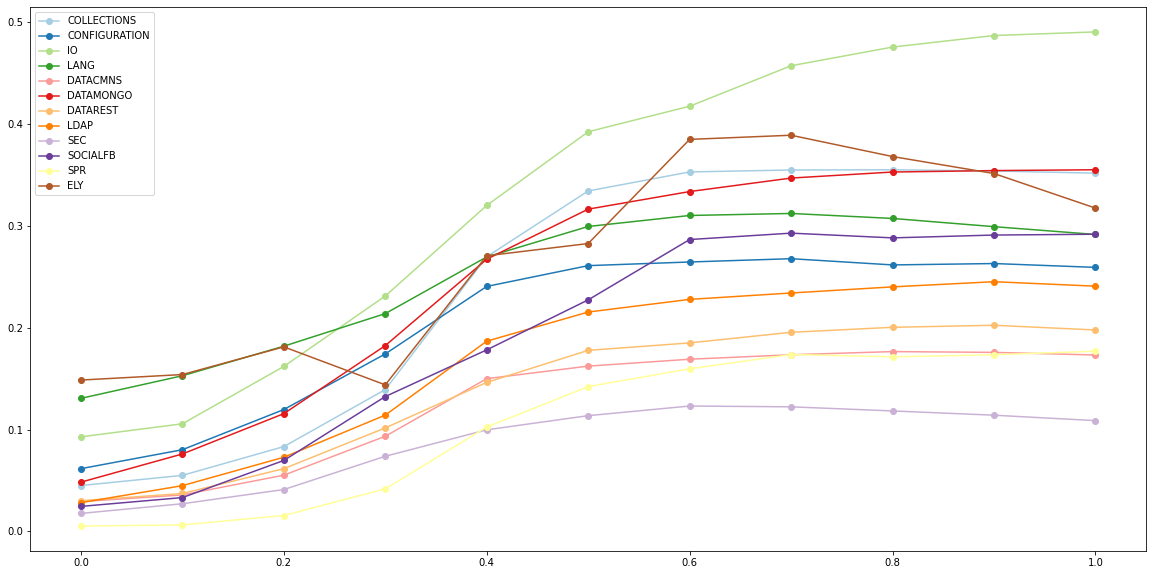

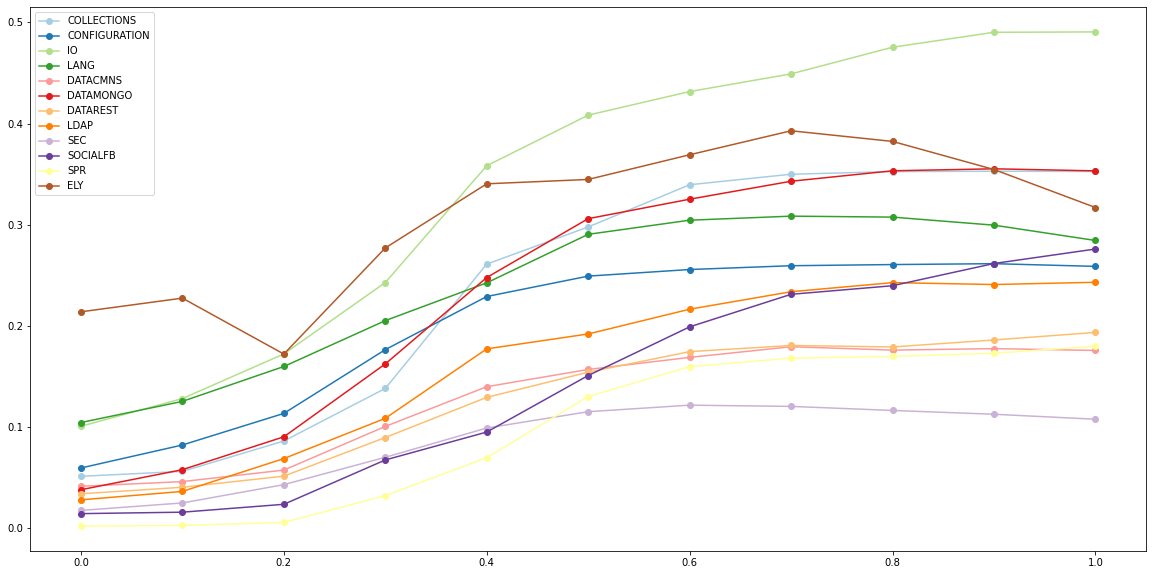

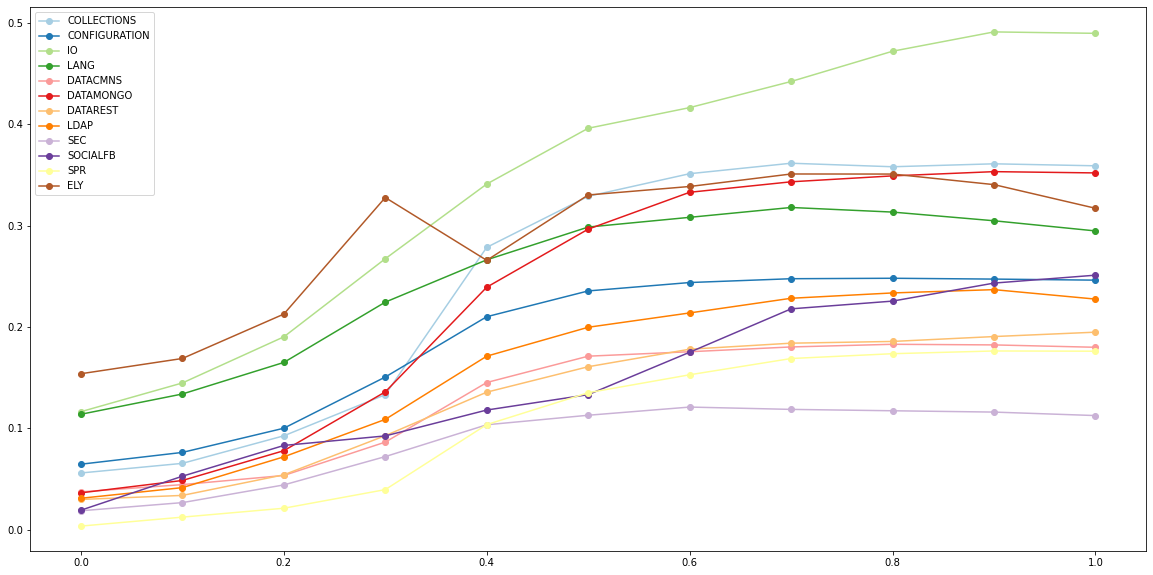

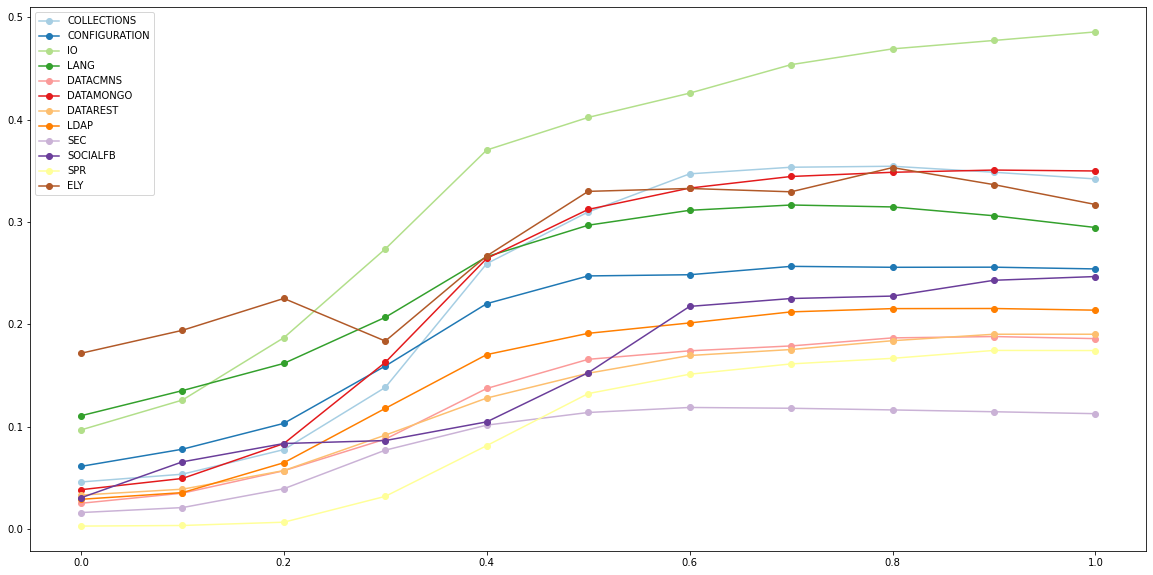

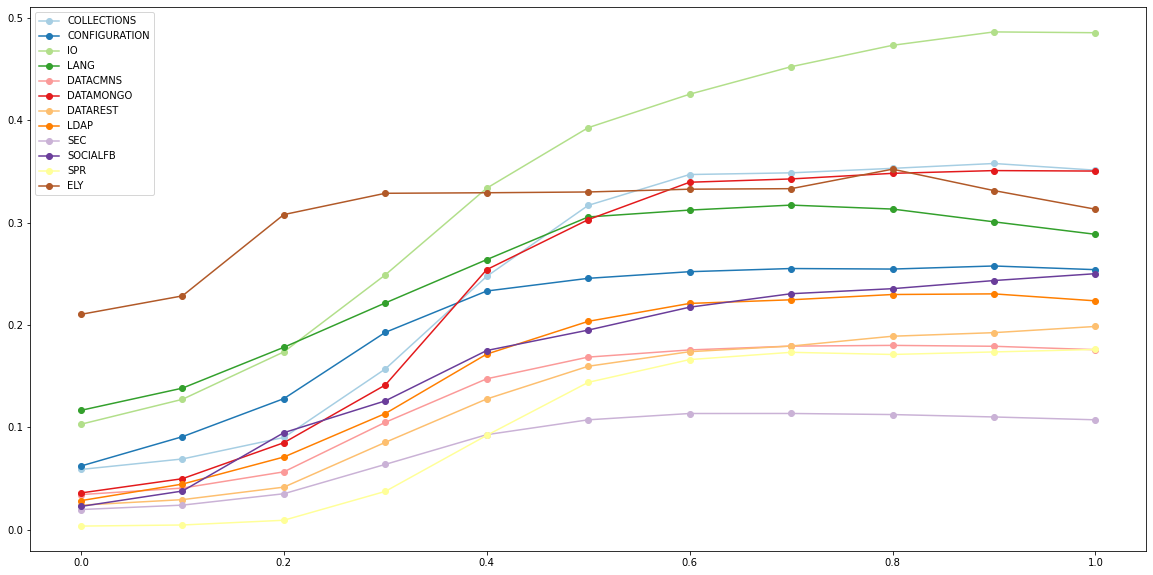

In [70]:
def alphaGraphs(df):
    plt.figure(figsize=(20,10))
    x_vals = []
    cmap = plt.get_cmap('Paired')
    for x in range(0, 11):
        x_vals.append(x/10)
    color_index = 0
    for index, row in df.iterrows():
        plt.plot(x_vals,row,label = index, marker='o', color = cmap(color_index))
        color_index +=1

    plt.legend()
    
for i in range(5):
    alphaGraphs(map_scores_list[i])

In [75]:
# Determine best performing alpha for each project 
def getBestPerforming(df):
    df['Best_Alpha'] = df[df.columns.difference(['Best_Alpha','Best_Alpha_Val','Direct_only_score'])].idxmax(axis=1)
    df['Best_Alpha_Val'] = df[df.columns.difference(['Best_Alpha','Best_Alpha_Val','Direct_only_score'])].max(axis=1)
    
    
for i in range(5):
    getBestPerforming(map_scores_list[i])
map_scores_list[0]

0.0       0.1       0.2       0.3       0.4       0.5  \
PROJECT                                                                     
COLLECTIONS    0.045057  0.055026  0.083252  0.139160  0.269433  0.333949   
CONFIGURATION  0.061614  0.080183  0.119588  0.174154  0.240335  0.260705   
IO             0.092823  0.105605  0.161874  0.230967  0.319735  0.392012   
LANG           0.130550  0.152720  0.181702  0.213671  0.269258  0.299101   
DATACMNS       0.029297  0.035849  0.055212  0.093387  0.149878  0.162165   
DATAMONGO      0.048384  0.076005  0.115566  0.182293  0.267025  0.316111   
DATAREST       0.030171  0.037258  0.061593  0.101584  0.146218  0.177641   
LDAP           0.028303  0.044947  0.072804  0.114116  0.186631  0.215211   
SEC            0.017723  0.027206  0.041127  0.073763  0.099711  0.113603   
SOCIALFB       0.024600  0.033247  0.069671  0.132333  0.178116  0.227142   
SPR            0.005289  0.006439  0.015667  0.041769  0.102423  0.142083   
ELY            0.148502  0.153905  0.181056  0.143794  0.270401  0.282384   

                    0.6       0.7       0.8       0.9       1.0 Best_Alpha  \
PROJECT                                                                      
COLLECTIONS    0.352596  0.354512  0.354723  0.353509  0.351412        0.8   
CONFIGURATION  0.264290  0.267522  0.261407  0.262767  0.259002        0.7   
IO             0.417028  0.456743  0.475065  0.486374  0.489924        1.0   
LANG           0.309904  0.311875  0.306992  0.298934  0.291280        0.7   
DATACMNS       0.168934  0.173312  0.176414  0.175647  0.173068        0.8   
DATAMONGO      0.333359  0.346600  0.352512  0.353938  0.354739        1.0   
DATAREST       0.184924  0.195350  0.200231  0.202234  0.197603        0.9   
LDAP           0.227609  0.233886  0.239880  0.244956  0.240565        0.9   
SEC            0.123030  0.122249  0.118209  0.114036  0.108718        0.6   
SOCIALFB       0.286311  0.292571  0.287938  0.290708  0.291501        0.7   
SPR            0.159551  0.173509  0.171283  0.173306  0.176790        1.0   
ELY            0.384527  0.388588  0.367692  0.351025  0.317135        0.7   

               Best_Alpha_Val  
PROJECT                        
COLLECTIONS          0.354723  
CONFIGURATION        0.267522  
IO                   0.489924  
LANG                 0.311875  
DATACMNS             0.176414  
DATAMONGO            0.354739  
DATAREST             0.202234  
LDAP                 0.244956  
SEC                  0.123030  
SOCIALFB             0.292571  
SPR                  0.176790  
ELY                  0.388588

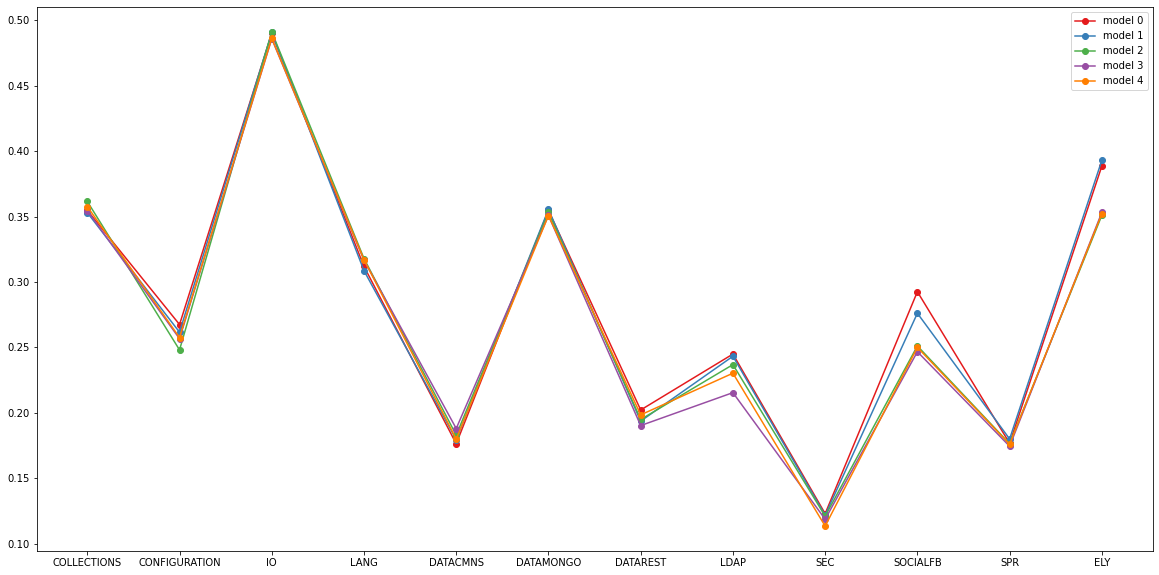

In [79]:
def modelComparisonScatter(df_list):
    plt.figure(figsize=(20,10))
    cmap = plt.get_cmap('Set1')
    for i in range(5):
        plt.plot(df_list[i].index,df_list[i]['Best_Alpha_Val'] , label = 'model ' + str(i), marker='o', color = cmap(i))
    plt.legend()
        
modelComparisonScatter(map_scores_list)
